<a href="https://colab.research.google.com/github/aivision2020/NeuralCollectiveUnconsciousness-/blob/main/explore_siren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an image dataset signal](#section_2)

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
#%matplotlib notebook
import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [34]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, with_representations=False, dataset_size=100):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.embeddings = nn.Embedding(dataset_size, out_features) if with_representations else None
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input, img_ids):
        ret = torch.sin(self.omega_0 * self.linear(input))
        if self.embeddings:
          return ret + self.embeddings(img_ids)[:,None,:]
        return ret
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features,
                 dataset_size, representation_layers = [0], outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30., pos_embed=None):
        super().__init__()
        
        
        if pos_embed is not None:
          self.pos_embed = pos_embed(hidden_features) 
          in_features=hidden_features
        else:
          self.pos_embed =  nn.Identity()
        self.net = []
        for i in range(hidden_layers):
          is_first = i==0
          self.net.append(SineLayer(in_features if is_first else hidden_features, hidden_features, hidden_features, is_first=is_first, 
                              omega_0=hidden_omega_0, 
                              with_representations=(i in representation_layers), dataset_size=dataset_size))

        if outermost_linear:
            self.final_layer = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                self.final_layer.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
        else:
            self.final_layer = SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0)
        
        self.net = nn.ModuleList(self.net)
    
    def forward(self, x, img_id):
        x = self.pos_embed(x)
        for layer in self.net:
          x = layer(x, img_id)
        return self.final_layer(x)

    def eval(self):
      for param in self.parameters():
        param.requires_grad = False
      for layer in self.net:
        if layer.embeddings is not None:
          for p in layer.embeddings.parameters():
            p.requires_grad = True
          
    def train(self):
      for param in self.parameters():
        param.requires_grad = True

img_siren = Siren(2, 64, 3, 3, 10, outermost_linear=True)
img_siren
#img_siren(model_input.cpu(), im_id.cpu())    


Siren(
  (pos_embed): Identity()
  (final_layer): Linear(in_features=64, out_features=3, bias=True)
  (net): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
      (embeddings): Embedding(10, 64)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
)

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [14]:
import glob
import cv2
import random

class ImageFitting(Dataset):
  def __init__(self, basedir, files, sidelength, index_offset=0) -> None:
      super().__init__()
      transform = Compose([
          Resize(sidelength),
          ToTensor(),
          Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
      self.imgs = [transform(
                    Image.fromarray(cv2.cvtColor(
                        cv2.imread(os.path.join(basedir, str(sidelength), f'{f}-{sidelength}.png')),
                        cv2.COLOR_BGR2RGB))) for f in files]
      self.pixels = [img.permute(1, 2, 0).view(-1, 3) for img in self.imgs]
      self.coords = get_mgrid(sidelength, 2)
      self.index_offset = index_offset
      #x and y are in range [-1,1] 
      #mask pixels with x,y values in the image center ± 0.1
      mask = self.coords.abs() <= 0.3
      self.mask = torch.bitwise_and(mask[:,0], mask[:,1])
      
  def __len__(self):    
    return len(self.imgs)

  def __getitem__(self, i):
    
    return self.coords, self.pixels[i], self.mask, i+self.index_offset

basedir = '/content/drive/MyDrive/dataset/NeuralCollectiveUnconsciousness/Data/'
train_res = 48
files = glob.glob(os.path.join(basedir, str(train_res), '*png'))
random.shuffle(files)
filenames = [os.path.basename(f).split('-')[0] for f in files]
print(len(files))
train_dataset = ImageFitting(basedir, filenames[:90], train_res)
eval_dataset = ImageFitting(basedir, filenames[90:], train_res, index_offset=len(train_dataset))
hires_dataset = ImageFitting(basedir, filenames[90:], 256)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), pin_memory=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), pin_memory=True, num_workers=0)


100


Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [5]:

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, representation_layers = [0],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True)
img_siren.cuda()
len(train_loader), len(eval_loader), len(train_dataset), len(eval_dataset)

(1, 1, 90, 10)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [6]:
from collections import defaultdict
def display(model_output, ground_truth, loss, step, steps_til_summary):
    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f}, batch_size {len(model_output)}")
        fig, axes = plt.subplots(1,4, figsize=(18,6))
        res = np.sqrt(len(model_output[0]))
        print(res)
        res = int(res)
        axes[0].imshow((model_output[0]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[1].imshow((model_output[1]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[2].imshow((model_output[2]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[3].imshow(((ground_truth-model_output)[0]).cpu().view(res, res, -1).detach().numpy())
        
        plt.show()


def fit_one_step(img_siren, loader, step, steps_till_summary):
  for model_input, ground_truth, mask, im_id in loader:
    model_input, ground_truth, im_id = model_input.cuda(), ground_truth.cuda(), im_id.cuda().long()
    model_output = img_siren(model_input, im_id)    
    loss = ((model_output - ground_truth)**2).mean()
    display(model_output, ground_truth, loss, step, steps_til_summary)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss.item()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.729277, batch_size 90
48.0


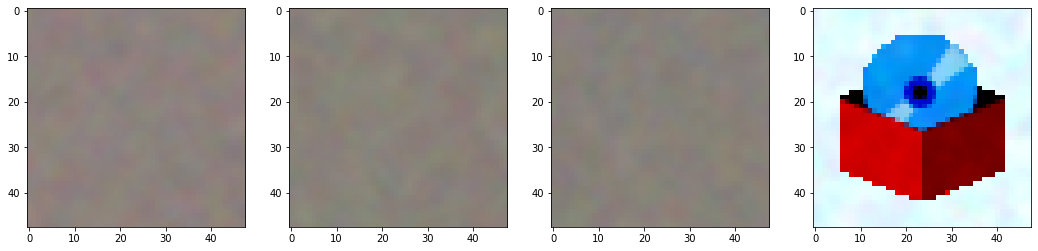

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.048034, batch_size 90
48.0


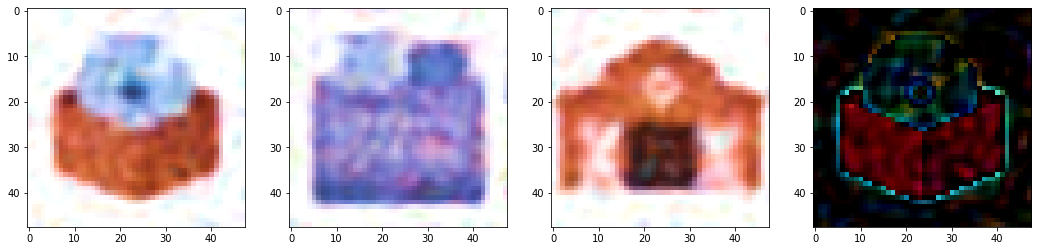

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total loss 0.023932, batch_size 90
48.0


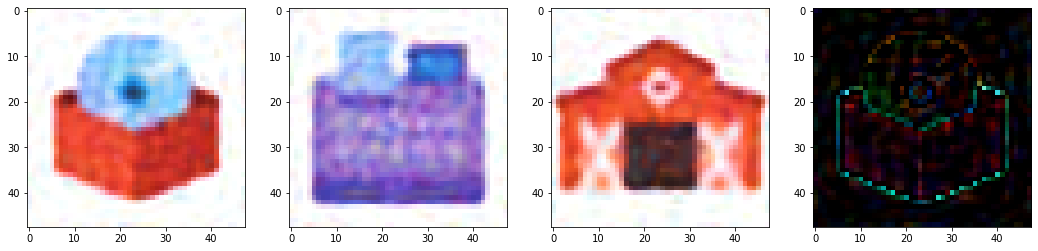

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.017066, batch_size 90
48.0


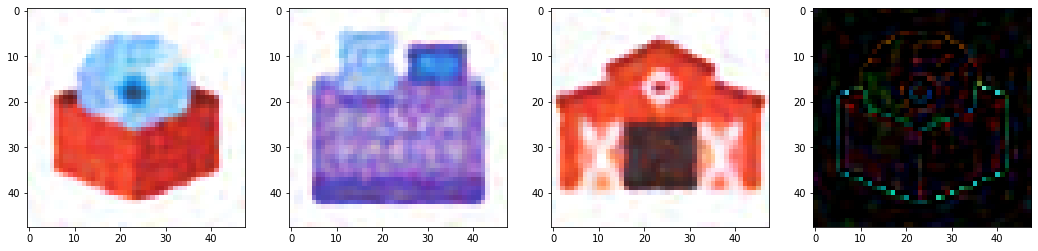

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400, Total loss 0.014817, batch_size 90
48.0


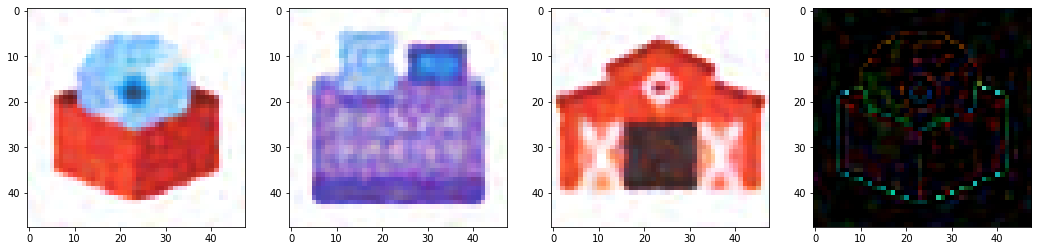

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.014472, batch_size 90
48.0


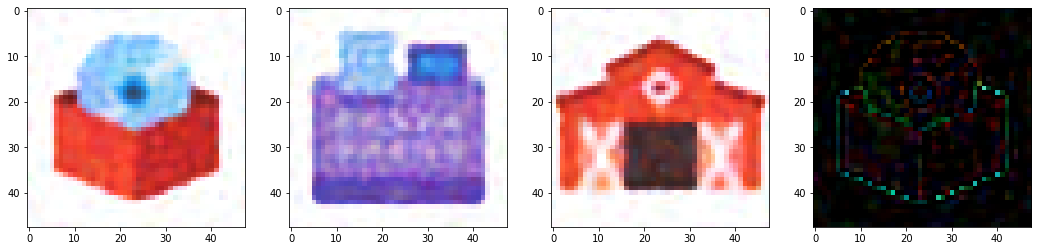

In [7]:

total_steps = 501
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)

metrics = defaultdict(list)
for step in range(total_steps):
  img_siren.train()
  metrics['baseline_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()

We see the general image is reconstructed. However, there is a lot of noise.  Let's try a deeper network


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.716534, batch_size 90


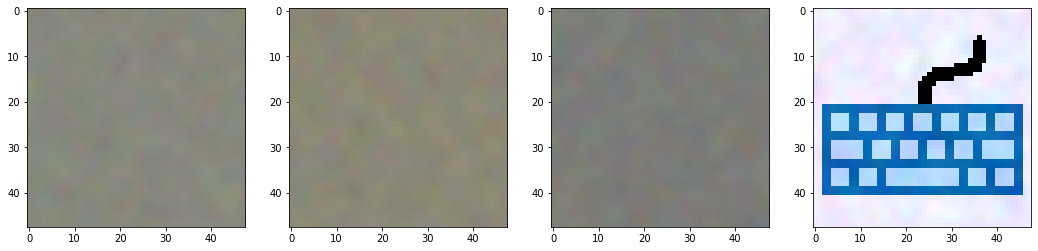

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.070113, batch_size 90


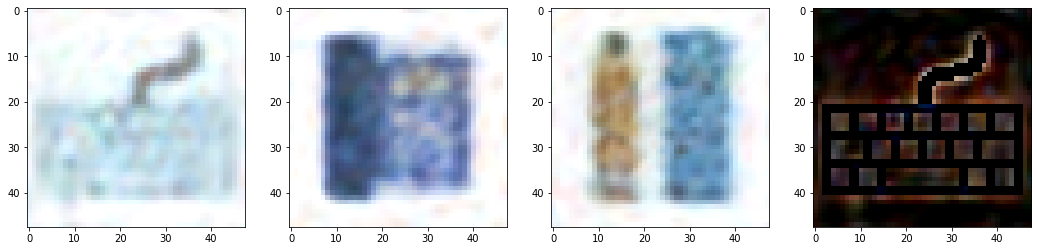

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total loss 0.024939, batch_size 90


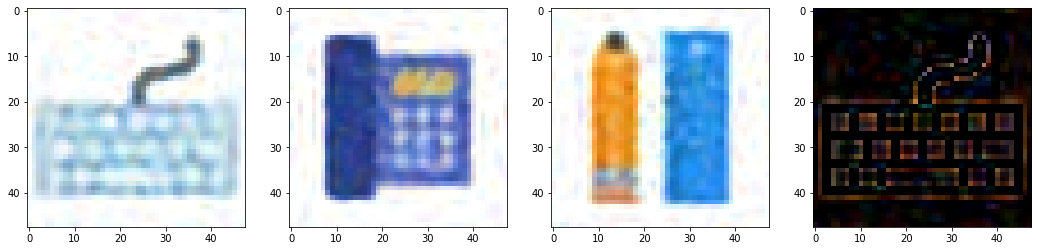

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.017191, batch_size 90


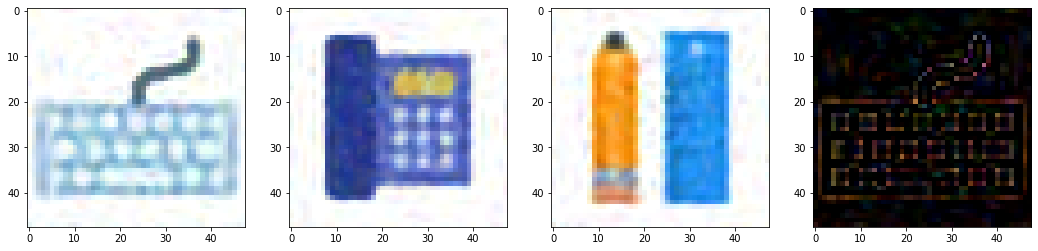

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400, Total loss 0.014871, batch_size 90


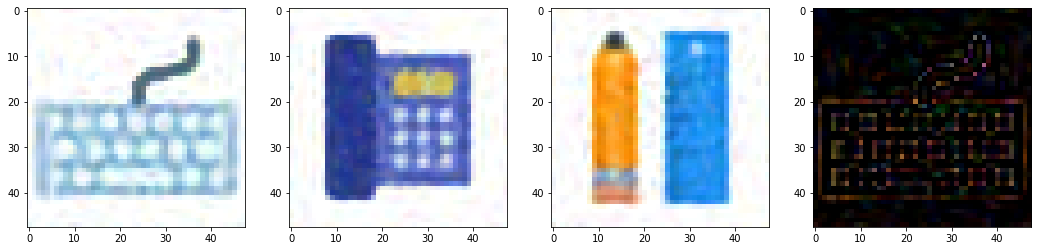

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.014520, batch_size 90


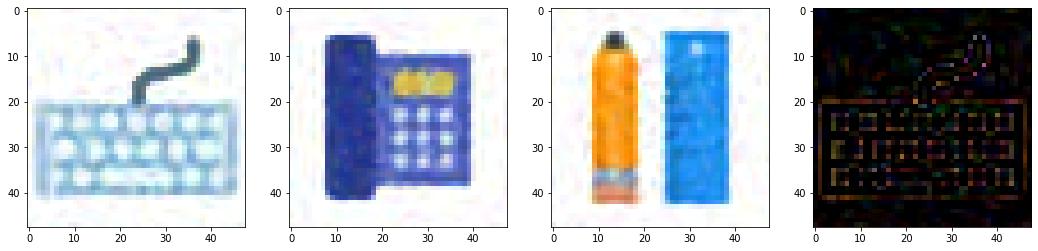

In [9]:
img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, representation_layers = [0,1,2],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True)
img_siren.cuda()


total_steps = 501
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
metrics = defaultdict(list)
for step in range(total_steps):
  img_siren.train()
  metrics['Multi-Level_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()


Well, That didn't change much. Lets try deeper network


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.761995, batch_size 90


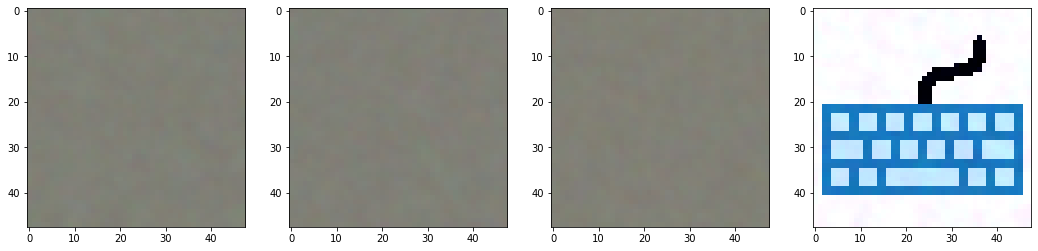

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.034126, batch_size 90


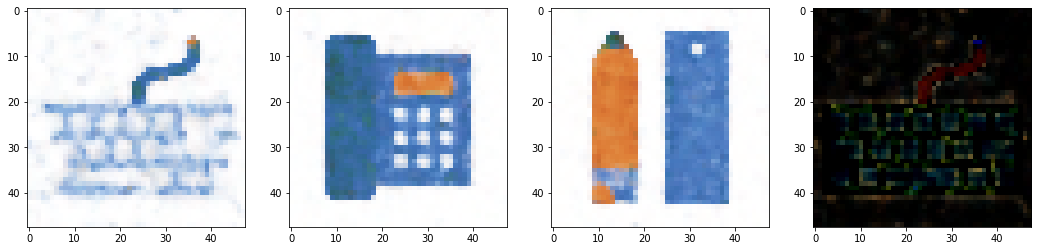

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total loss 0.005683, batch_size 90


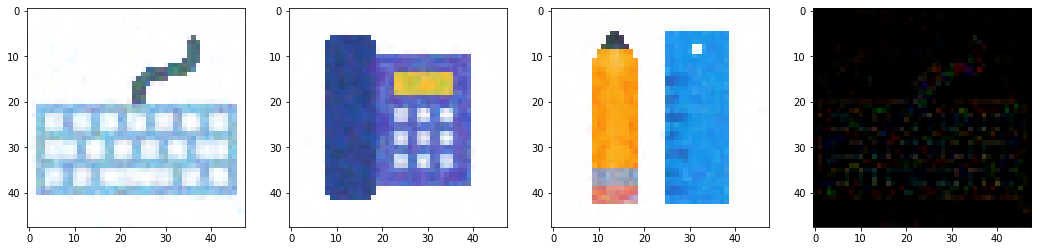

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.002803, batch_size 90


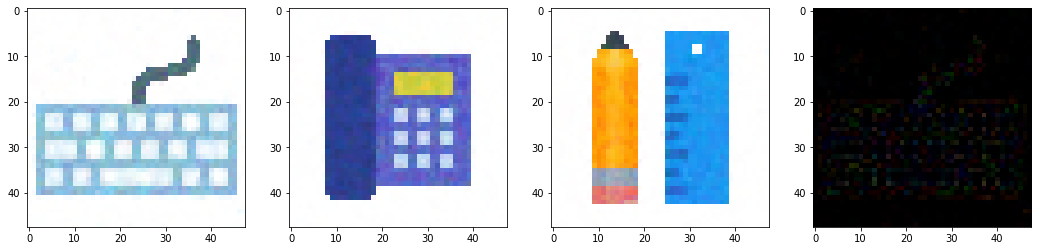

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400, Total loss 0.002236, batch_size 90


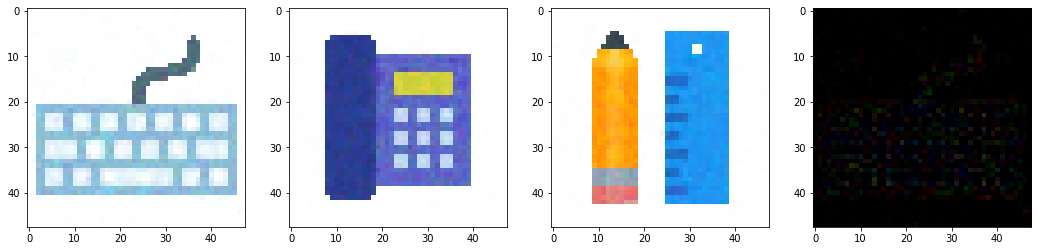

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.002158, batch_size 90


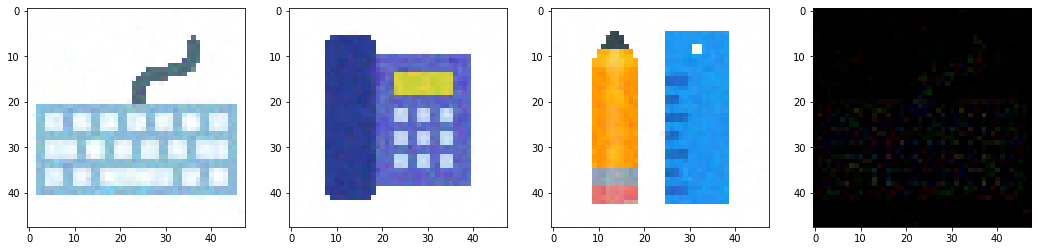

In [10]:
img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=10, representation_layers = [0],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True)
img_siren.cuda()

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
for step in range(total_steps):
  img_siren.train()
  metrics['deep_network_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()


That's nice, but still noisy, let's add Multi-Level Representations

In [ ]:
img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=10, representation_layers = [0,3,6,9],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True)
img_siren.cuda()

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
for step in range(total_steps):
  img_siren.train()
  metrics['deep_network_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()


Genrealization. We'll test unseen images, higher resolutions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total loss 0.436939, batch_size 10


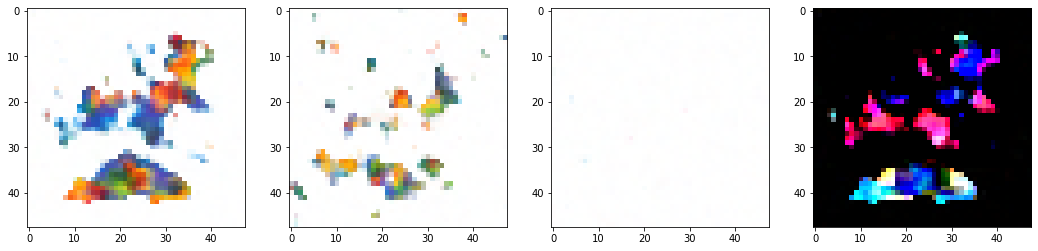

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total loss 0.422925, batch_size 10


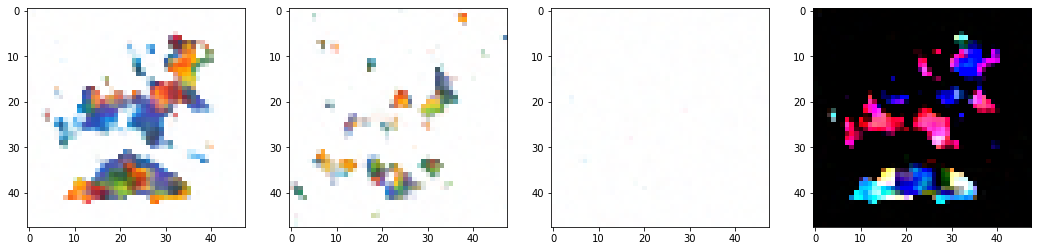

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total loss 0.409384, batch_size 10


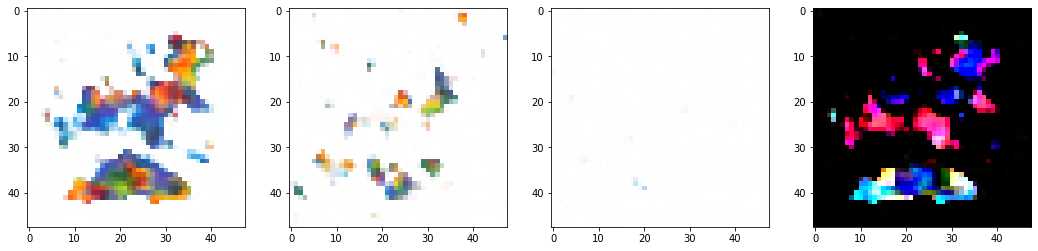

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 300, Total loss 0.397252, batch_size 10


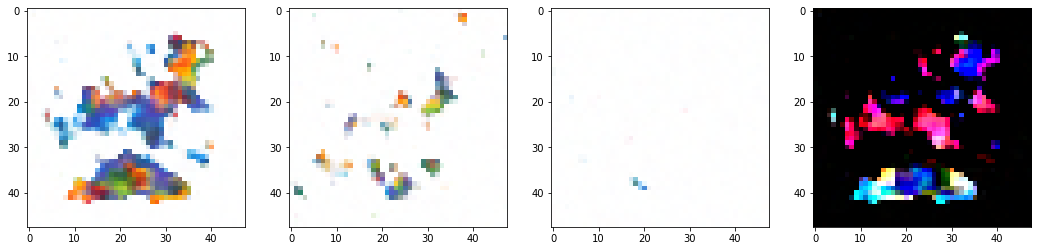

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 400, Total loss 0.384790, batch_size 10


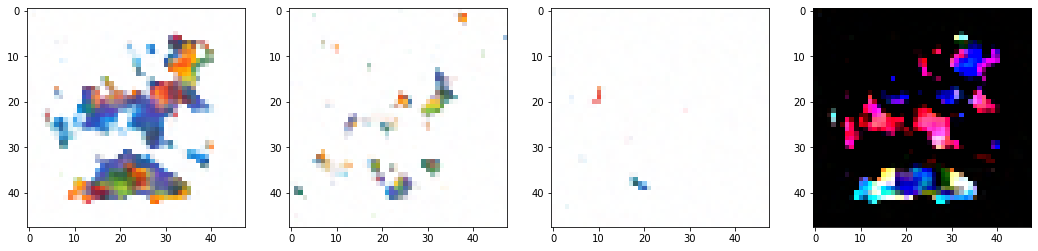

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total loss 0.372511, batch_size 10


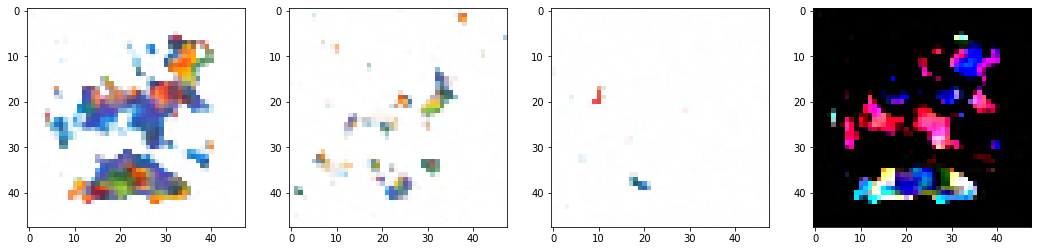

In [12]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
for step in range(total_steps):
  img_siren.eval()
  metrics['unseen_images_loss'].append(fit_one_step(img_siren, eval_loader, step, steps_til_summary))
  scheduler.step()


Step 0, Total loss 2.444838, batch_size 3
256.0


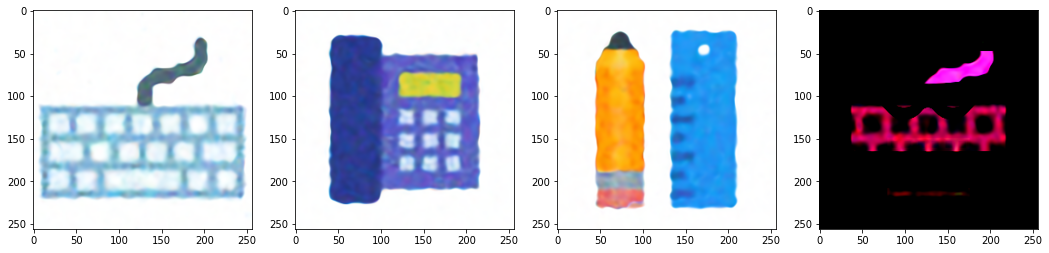

In [19]:


img_siren.train()
hires_loader = DataLoader(hires_dataset, batch_size=len(train_dataset), pin_memory=True, num_workers=0)
model_input, ground_truth, mask, im_id = next(iter(hires_loader))
model_input, ground_truth, im_id = model_input[:3].cuda(), ground_truth[:3].cuda(), im_id[:3].cuda().long()
model_output = img_siren(model_input, im_id)    
loss = ((model_output - ground_truth)**2).mean()
display(model_output, ground_truth, loss, 0, 1)

In [26]:
torch.cuda.empty_cache()

In [1]:
[plt.plot(v, label=k) for k,v in metrics.items()]
plt.legend()
plt.title('In/Out distribution reconstruction loss')

NameError: ignored

Step 0, Total loss 0.793089, batch_size 90


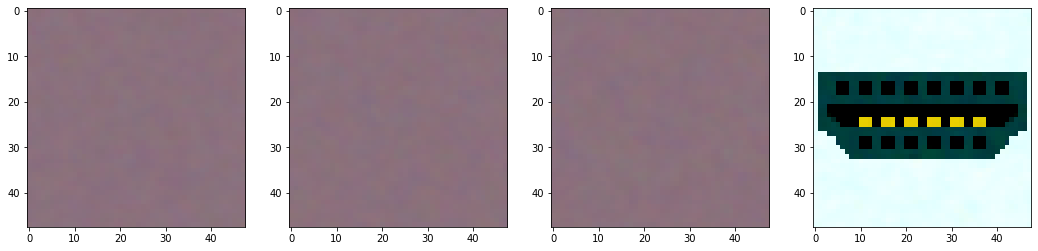

Step 100, Total loss 0.037332, batch_size 90


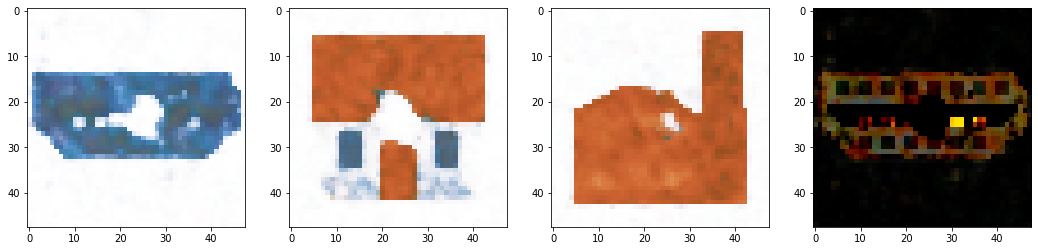

Step 200, Total loss 0.007680, batch_size 90


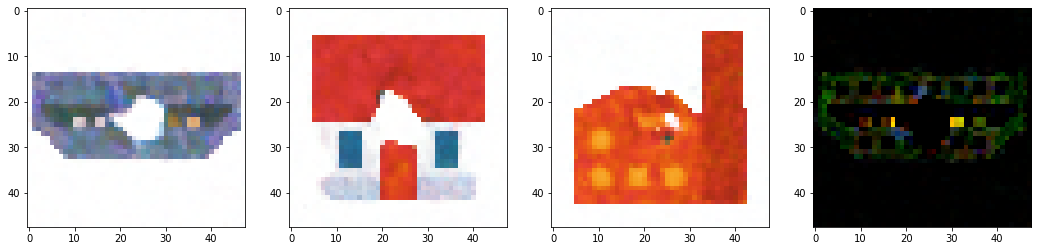

Step 300, Total loss 0.003285, batch_size 90


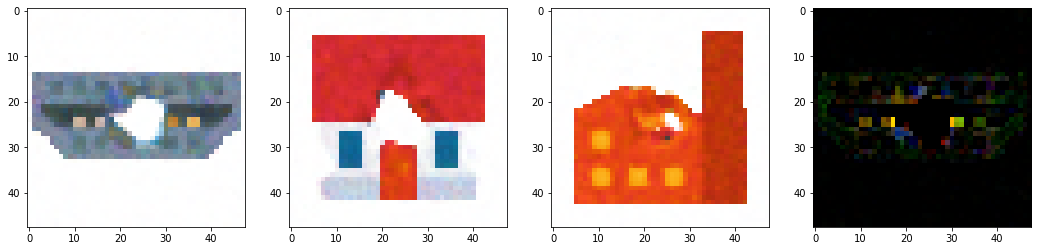

Step 400, Total loss 0.002528, batch_size 90


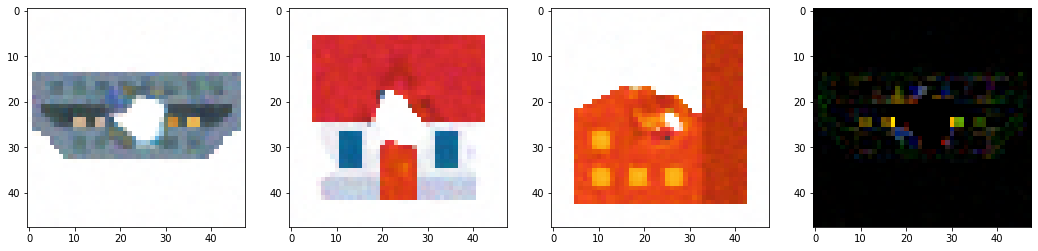

Step 500, Total loss 0.002427, batch_size 90


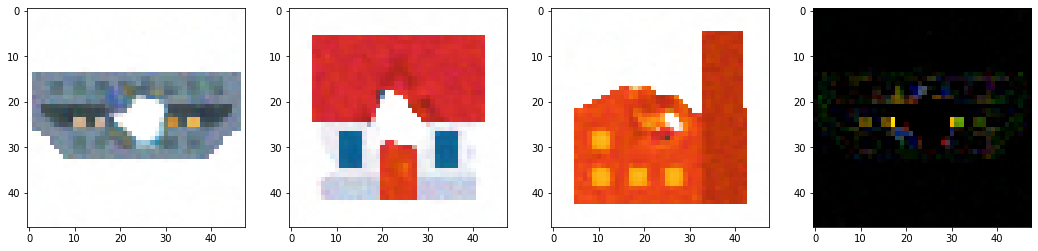

In [38]:
def display(model_output, ground_truth, loss, step, steps_til_summary):
    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f}, batch_size {len(model_output)}")
        fig, axes = plt.subplots(1,4, figsize=(18,6))
        res = int(np.sqrt(len(model_output[0])))
        axes[0].imshow((model_output[0]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[1].imshow((model_output[1]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[2].imshow((model_output[2]*0.5+0.5).cpu().view(res, res, -1).detach().numpy())
        axes[3].imshow(((ground_truth-model_output)[0]).cpu().view(res, res, -1).detach().numpy())
        plt.show()


def fit_one_step(img_siren, loader, step, steps_till_summary):
  for model_input, ground_truth, mask, im_id in loader:
    model_input, ground_truth, im_id = model_input.cuda(), ground_truth.cuda(), im_id.cuda().long()
    model_output = img_siren(model_input, im_id)    
    loss = ((model_output - ground_truth)**2)
    train_loss, eval_loss = loss[~mask].mean(), loss[mask].mean()
    display(model_output, ground_truth, train_loss, step, steps_til_summary)
    
    optim.zero_grad()
    train_loss.backward()
    optim.step()
    return train_loss.item(), eval_loss.item()

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=10, representation_layers = [0],
                  dataset_size=len(train_dataset), outermost_linear=True)
img_siren.cuda()


optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
for step in range(total_steps):
  img_siren.train()
  _, eval_loss = fit_one_step(img_siren, train_loader, step, steps_til_summary)
  metrics['inpaint_loss'].append(eval_loss)
  
  scheduler.step()


Siren(
  (pos_embed): SinusoidalEmbeddings()
  (final_layer): Linear(in_features=256, out_features=3, bias=True)
  (net): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (embeddings): Embedding(100, 256)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (8): SineLayer(
      (linear): Linear(in_features=256, out_fe

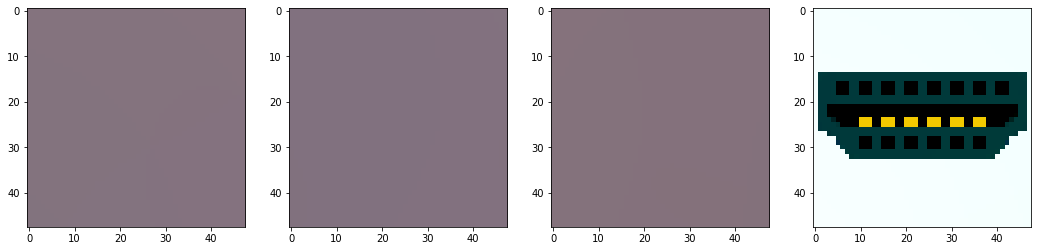

Step 100, Total loss 0.089398, batch_size 90


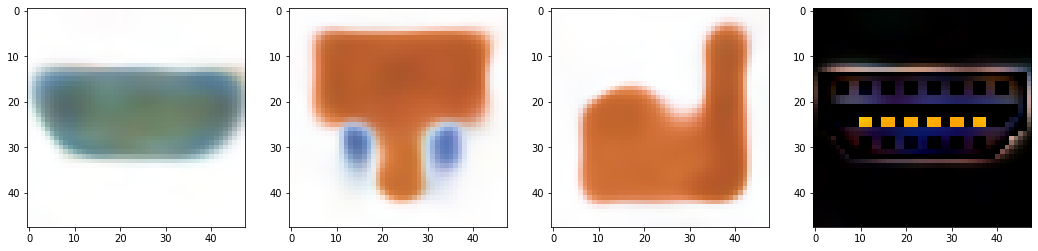

Step 200, Total loss 0.030219, batch_size 90


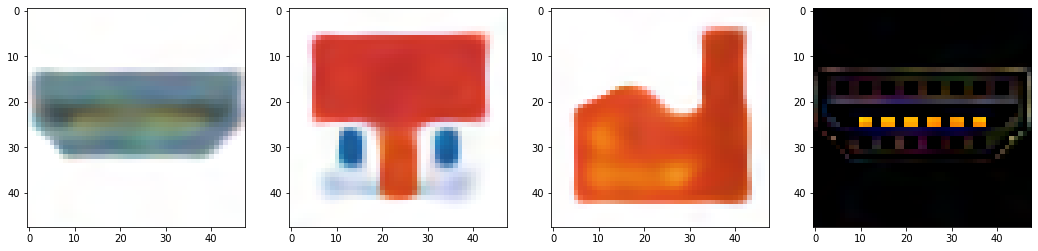

Step 300, Total loss 0.012556, batch_size 90


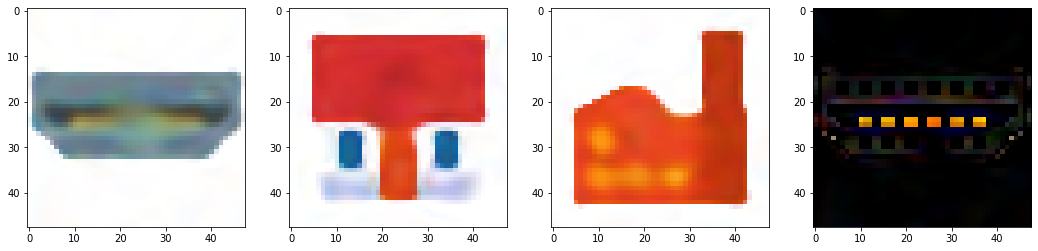

Step 400, Total loss 0.009750, batch_size 90


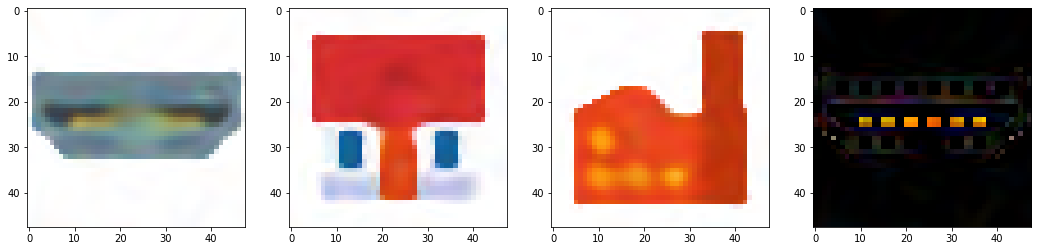

Step 500, Total loss 0.009360, batch_size 90


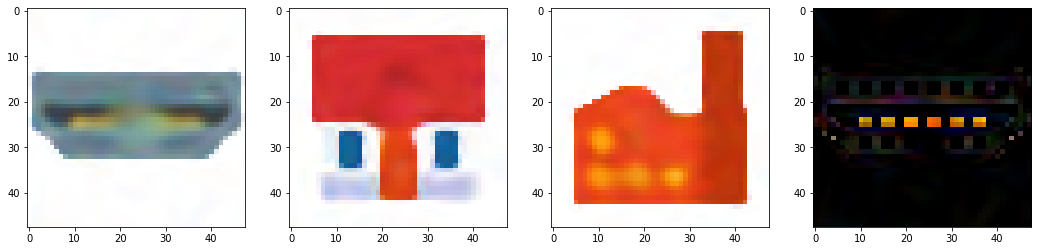

In [37]:

import math
def build_sinusoidal_embeddings(positions: torch.Tensor,
                                embedding_dim: int) -> torch.FloatTensor:
    """
    Adapted from fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert positions.ndim == 2  # [batch, position]
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(
        torch.arange(half_dim, dtype=torch.float, device=positions.device) *
        -emb)
    emb = positions.unsqueeze(-1) * emb.view(1, 1, -1)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:
        # zero pad
        emb = torch.cat([emb, torch.zeros_like(emb[:, :, :1])], dim=-1)
    return emb


class SinusoidalEmbeddings(nn.Module):

    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, positions: torch.Tensor) -> torch.FloatTensor:
        """
        positions: [batch, position]
                   Can be integers or floats (e.g. position 4.5)
        """
        return torch.cat([build_sinusoidal_embeddings(positions[:, :, i], self.embedding_dim//2)
                                for i in range(positions.shape[2])], dim=2)
  
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=10, representation_layers = [0],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True,
                  pos_embed=SinusoidalEmbeddings)
img_siren.cuda()
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
for step in range(total_steps):
  img_siren.train()
  metrics['deep_network_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()




Step 0, Total loss 0.733415, batch_size 90


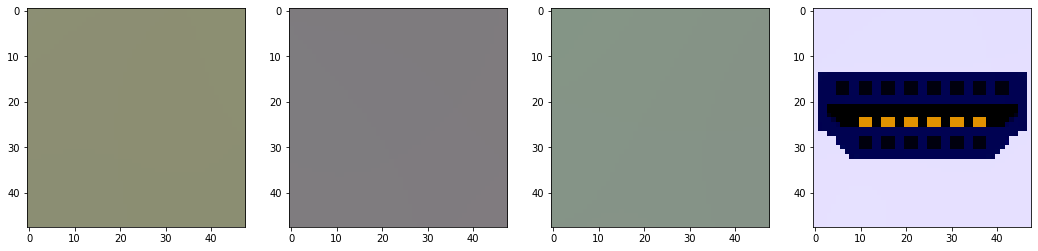

Step 100, Total loss 0.084283, batch_size 90


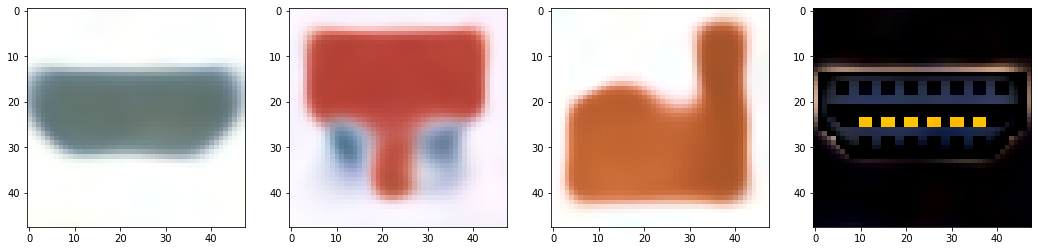

Step 200, Total loss 0.026542, batch_size 90


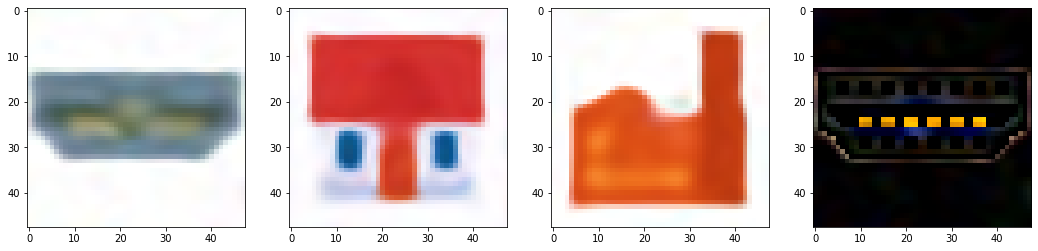

Step 300, Total loss 0.030159, batch_size 90


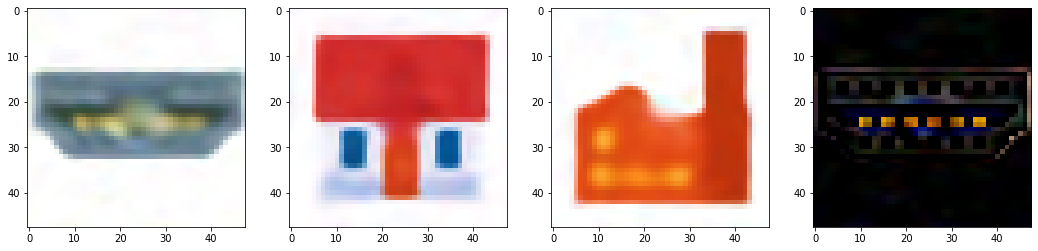

Step 400, Total loss 0.042466, batch_size 90


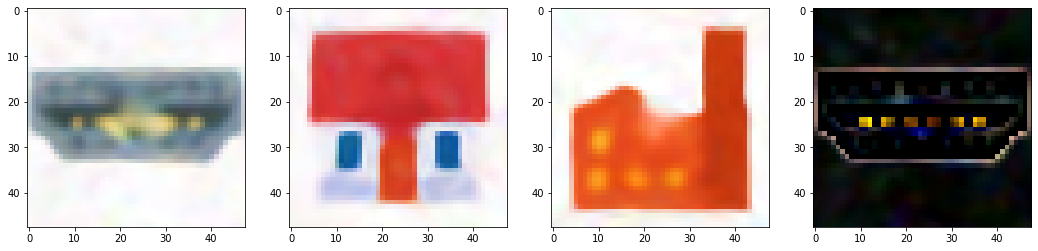

Step 500, Total loss 0.007834, batch_size 90


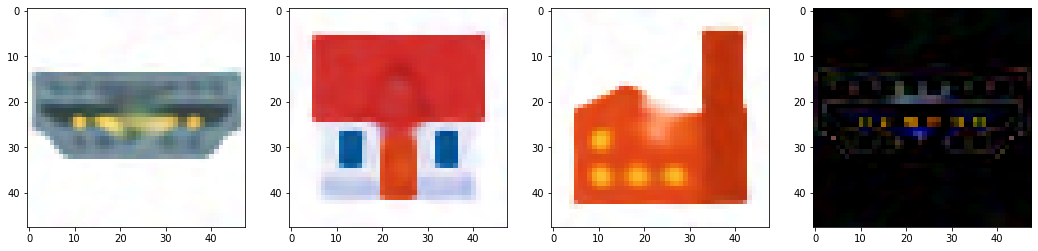

Step 600, Total loss 0.002114, batch_size 90


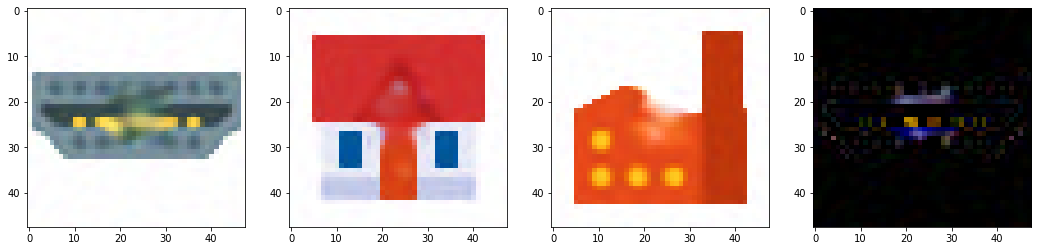

Step 700, Total loss 0.001196, batch_size 90


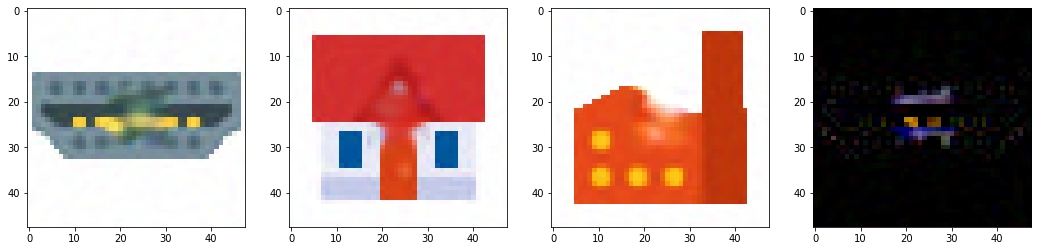

Step 800, Total loss 0.000790, batch_size 90


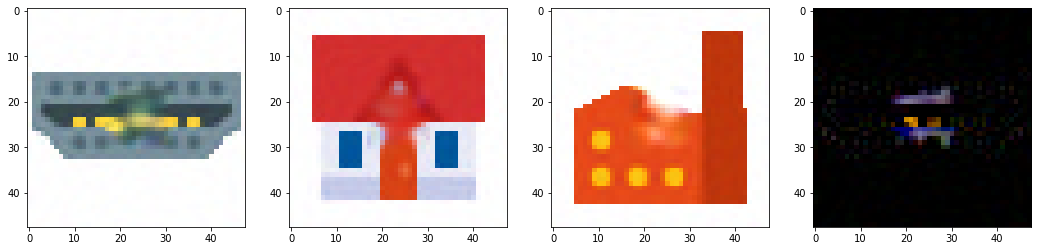

Step 900, Total loss 0.000571, batch_size 90


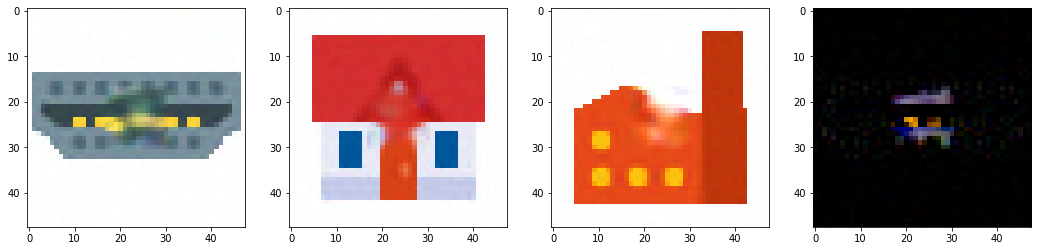

Step 1000, Total loss 0.000442, batch_size 90


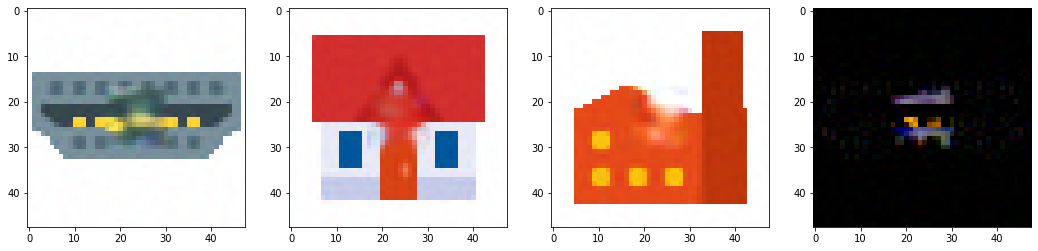

Step 1100, Total loss 0.000362, batch_size 90


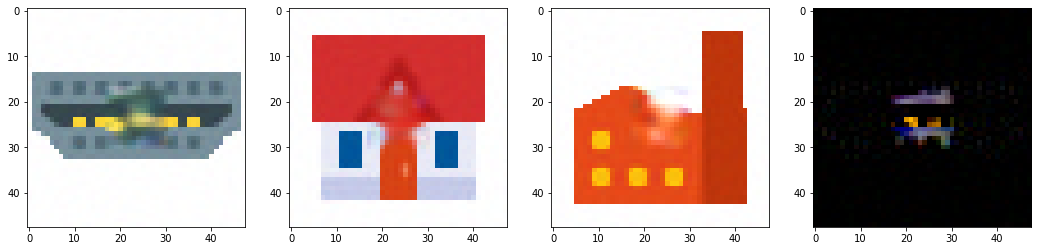

Step 1200, Total loss 0.000307, batch_size 90


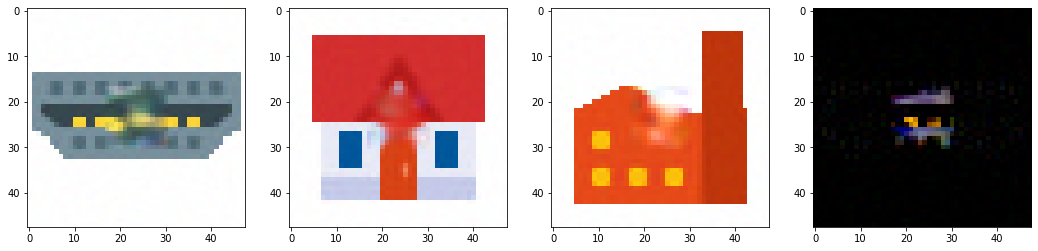

Step 1300, Total loss 0.000268, batch_size 90


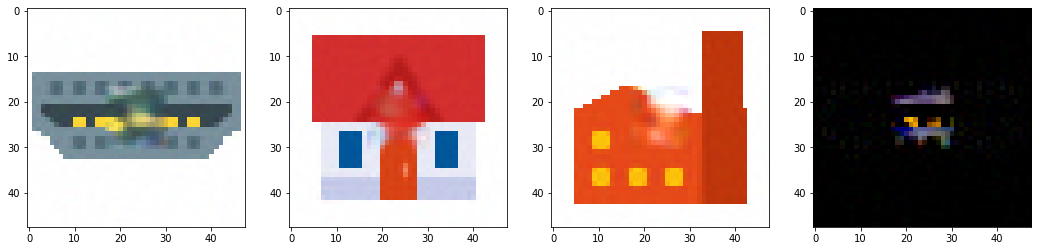

Step 1400, Total loss 0.000240, batch_size 90


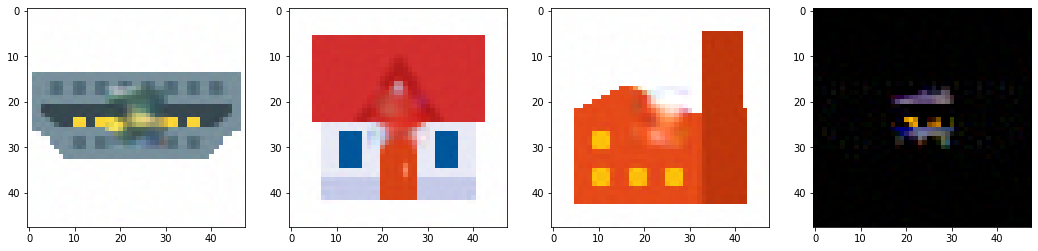

Step 1500, Total loss 0.000218, batch_size 90


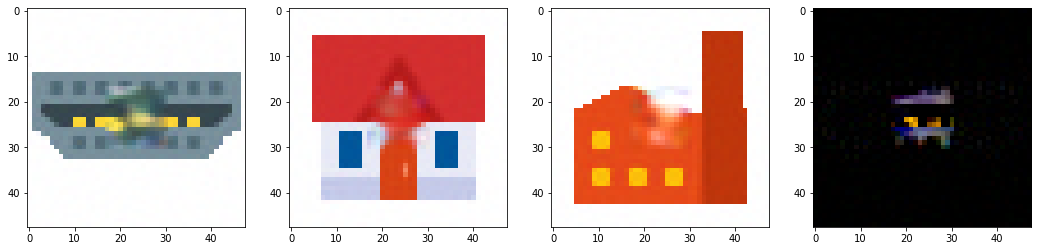

Step 1600, Total loss 0.000202, batch_size 90


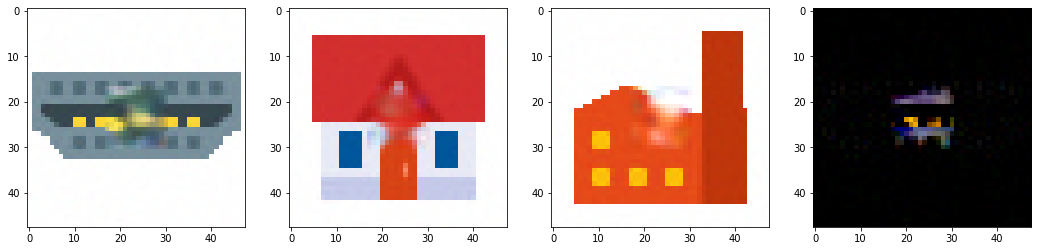

Step 1700, Total loss 0.000189, batch_size 90


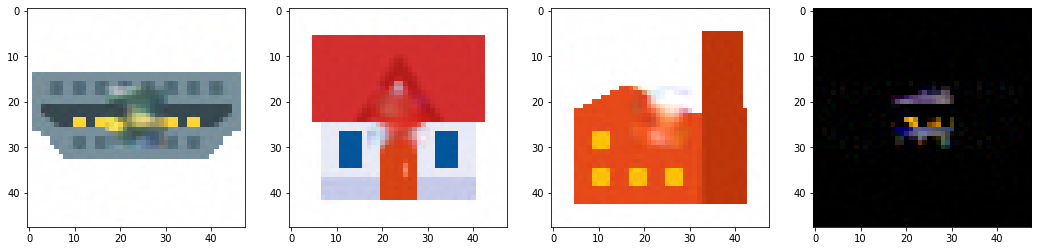

Step 1800, Total loss 0.000180, batch_size 90


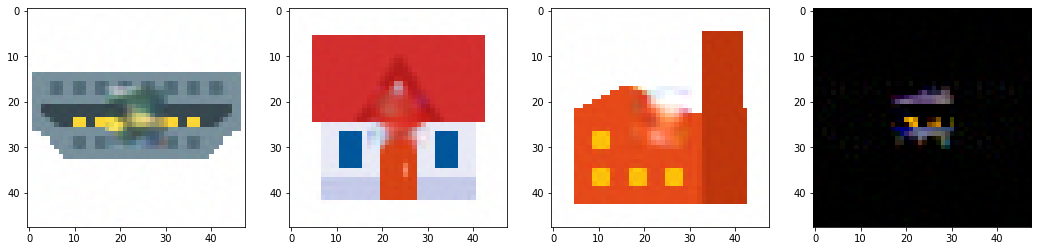

Step 1900, Total loss 0.000173, batch_size 90


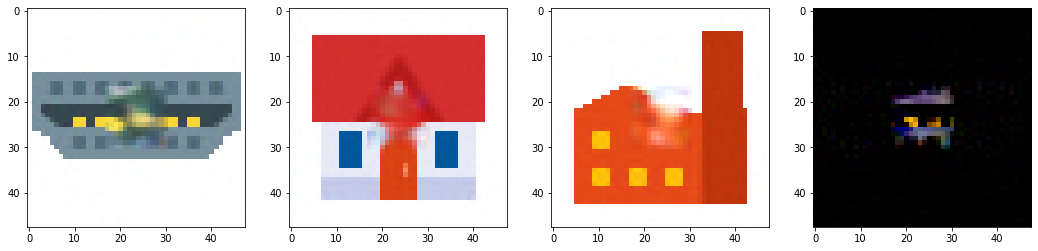

Step 2000, Total loss 0.000167, batch_size 90


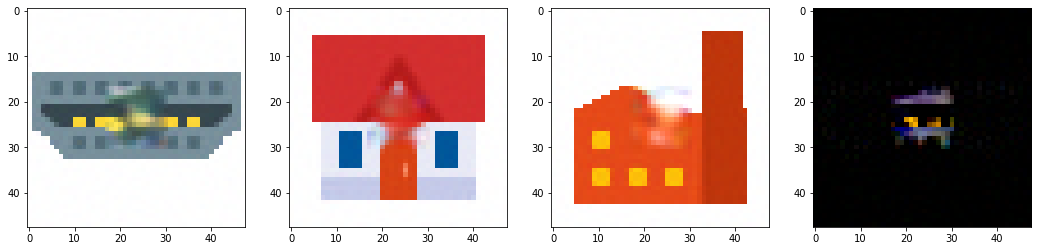

Step 2100, Total loss 0.000164, batch_size 90


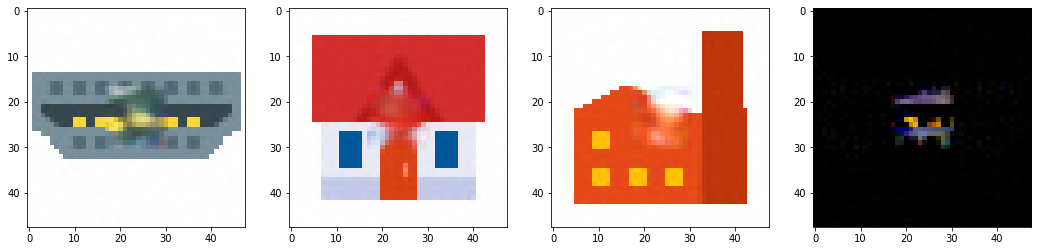

Step 2200, Total loss 0.000162, batch_size 90


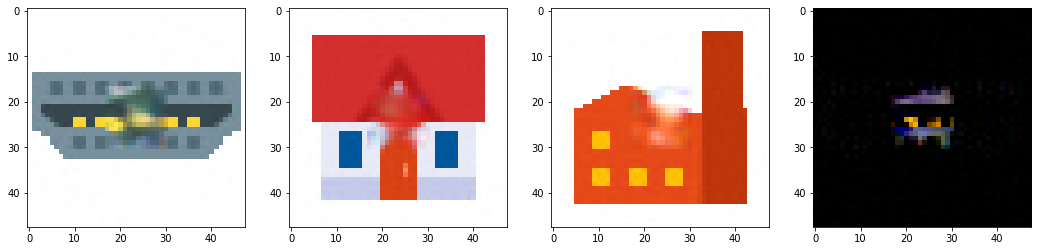

Step 2300, Total loss 0.000160, batch_size 90


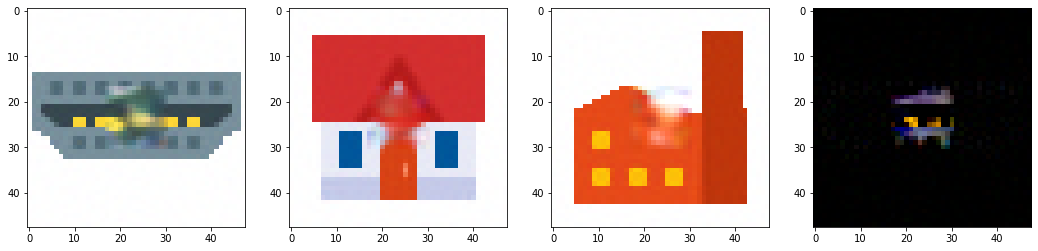

Step 2400, Total loss 0.000160, batch_size 90


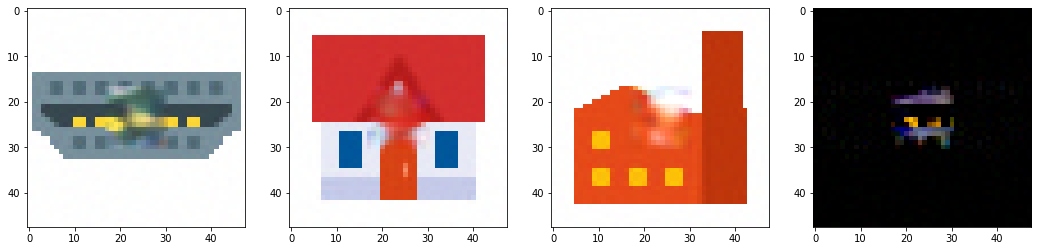

Step 2500, Total loss 0.000160, batch_size 90


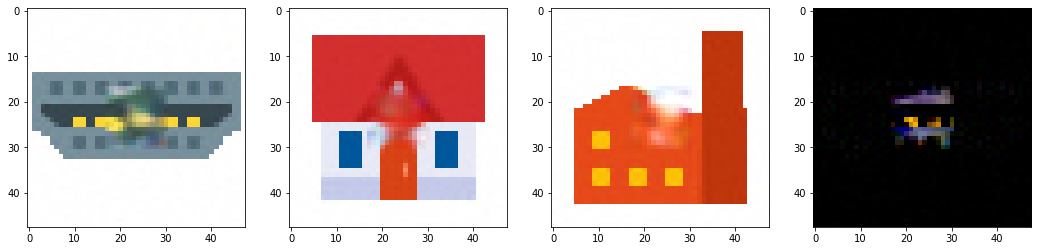

In [40]:
img_siren = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=10, representation_layers = [0,3,6,9],
                  dataset_size=len(train_dataset)+len(eval_dataset), outermost_linear=True,
                  pos_embed=SinusoidalEmbeddings)
img_siren.cuda()
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps*5)
for step in range(total_steps*5):
  img_siren.train()
  metrics['deep_network_loss'].append(fit_one_step(img_siren, train_loader, step, steps_til_summary))
  scheduler.step()


In [ ]:
model_input, ground_truth, mask, im_id = next(iter(hires_loader))
model_input, ground_truth, im_id = model_input[:3].cuda(), ground_truth[:3].cuda(), im_id[:3].cuda().long()
model_output = img_siren(model_input, im_id)    
loss = ((model_output - ground_truth)**2).mean()
display(model_output, ground_truth, loss, 0, 1)